In [4]:
rfile='https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/TMP/run00111.mid.gz'


In [5]:
rfile.split('/')[-1]

'run00111.mid.gz'

In [3]:
import os
if "JUPYTER_SERVER_ROOT" in os.environ:
    JUPYTER_SERVER_ROOT=os.environ['JUPYTER_SERVER_ROOT']
else:
    JUPYTER_SERVER_ROOT=''
print(JUPYTER_SERVER_ROOT)

In [2]:
import boto3
from boto3sts import credentials as creds
import pandas as pd

aws_session = creds.assumed_session("dodas")
s3 = aws_session.client('s3', endpoint_url="https://minio.cloud.infn.it/", config=boto3.session.Config(signature_version='s3v4'),verify=True)
response = s3.list_objects(Bucket='cygno-sim')['Contents']
for i, file in enumerate(response):
    print(file['Key'], file['LastModified'])
#file_db = pd.read_json(file_list)
#print (file_db)

OidcAgentConnectError: OIDC_SOCK env var not set

In [8]:

class myError(Exception):
    pass


def cache_file(url, cachedir='/tmp/', verbose=False):
    import os
    import sys
    import urllib
    from platform import python_version
    if not os.path.exists(cachedir):
        os.mkdir(cachedir)
    tmpname = cachedir+url.split('/')[-1]
    if not os.path.exists(tmpname):
        if verbose: print("downloading: "+tmpname)
        if python_version().split('.')[0]=='3':
            urllib.request.urlretrieve(url, tmpname, reporthook)
        else:
            urllib.urlretrieve(url, tmpname, reporthook)
    else:
        if verbose: sys.stderr.write('file '+tmpname+' cached')
        
    return tmpname

def reporthook(blocknum, blocksize, totalsize, verbose=True):
    import sys
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        if verbose: sys.stderr.write(s)
        if readsofar >= totalsize: # near the end
            if verbose: sys.stderr.write("\n")
    else: # total size is unknown
        if verbose: sys.stderr.write("read %d\n" % (readsofar,))
            
def get_mid_s32tmp(run, cachedir='/tmp/',tag = 'LNGS' , bucket='cygno-data', 
                   session='infncloud-iam', verbose=False):
    import os
    import sys
    if not os.path.exists(cachedir):
        os.mkdir(cachedir)
    filein  = ('/run%05d.mid.gz' % run)
    filetmp = cachedir+filein
    if not os.path.exists(filetmp):
        if verbose: print("downloading: "+filetmp)
        obj_get(tmpname, filetmp,tag , bucket, session, verbose)
    else:
        if verbose: sys.stderr.write('file '+filetmp+' cached')
        
    return filetmp

def write2root(fname, img, id=0, option='update', verbose=False):
    import ROOT
    tf = ROOT.TFile.Open(fname+'.root', option)
    img=img.T
    (nx,ny) = img.shape
    h2 = ROOT.TH2D('pic_run',fname+'_'+str(id),nx,0,nx,ny,0,ny)
    h2.GetXaxis().SetTitle('x')
    h2.GetYaxis().SetTitle('y')
    [h2.SetBinContent(bx,by,img[bx,by]) for bx in range(nx) for by in range(ny)]
    h2.Write()
    tf.Close()
    
def TGraph2array(tgraph, verbose=False):
    import ctypes
    xl = []; yl = []
    for i in range(tgraph.GetN()):
        xi = ctypes.c_double(); yi = ctypes.c_double()
        tgraph.GetPoint(i,xi,yi)
        xl.append(xi.value)
        yl.append(yi.value)
    x = np.array(xl)
    y = np.array(yl)
    return x, y

def rootTH2byname(root_file, verbose=False):
    pic = []
    wfm = []
    for i,e in enumerate(root_file.GetListOfKeys()):
        che = e.GetName()
        if ('pic_run' in str(che)):
            pic.append(che)
        elif ('wfm_run' in str(che)):
            wfm.append(che)
    return pic, wfm

BAKET_POSIX_PATH = '/jupyter-workspace/cloud-storage/'
BAKET_REST_PATH = 'https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/'


def root_file(run, tag='LAB', cloud=False, verbose=False):
    if cloud:
        BASE_URL  = BAKET_REST_PATH+'cygno-data/'
        if run <= 4504:
            BASE_URL  =  BAKET_REST_PATH+'cygnus/Data/'
        f  = BASE_URL+(tag+'/histograms_Run%05d.root' % run)
    else:
        f = (tag+'/histograms_Run%05d.root' % run)
        
    if verbose: print(f)
    return f

def mid_file(run, tag='LNGS', cloud=False, verbose=False):
    if cloud:
        BASE_URL  = BAKET_REST_PATH+'cygno-data/'
        f = BASE_URL+(tag+'/run%05d.mid.gz' % run)
    else:
        f = ('/run%05d.mid.gz' % run)
    if verbose: print(f)
    return f


def open_mid(run, path='/tmp/',  cloud=True,  tag='LNGS', verbose=False):
    import midas.file_reader
    fname = mid_file(run, tag=tag, cloud=cloud, verbose=verbose)
    if verbose: print(fname)
    if not cloud:
        if os.path.exists(path+fname):
            f = midas.file_reader.MidasFile(path+fname)
        else:
            raise myError("openFileError: "+fname+" do not exist") 
    else:
        filetmp = cache_file((fname), cachedir=path, verbose=verbose)
        f = midas.file_reader.MidasFile(filetmp)  
    return f


def open_root(run, path='/tmp/',  cloud=True,  tag='LAB', verbose=False):
    import ROOT
    import root_numpy as rtnp
    fname = root_file(run, tag=tag, cloud=cloud, verbose=verbose)
    if not cloud:
        fname=path+fname
    class cfile:
        def __init__(self, file, pic, wfm, max_pic, max_wfm, x_resolution, y_resolution):
            self.file         = file
            self.pic          = pic 
            self.wfm          = wfm
            self.max_pic      = max_pic
            self.max_wfm      = max_wfm
            self.x_resolution = x_resolution
            self.y_resolution = y_resolution
    try:
        f=ROOT.TFile.Open(fname)
        pic, wfm = rootTH2byname(f)
        image = rtnp.hist2array(f.Get(pic[0])).T
        x_resolution = image.shape[1]
        y_resolution = image.shape[0]
        max_pic = len(pic)
        max_wfm = len(wfm)
    except:
        raise myError("openFileError: "+fname)

    if verbose:
        print ('Open file: '+fname)
        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        print ("# of Images (TH2) Files: %d " % (max_pic))
        print ("# of Waveform (TH2) Files: %d " % (max_wfm))
        print ('Camera X, Y pixel: {:d} {:d} '.format(x_resolution, y_resolution))
    return cfile(f, pic, wfm, max_pic, max_wfm, x_resolution, y_resolution)


def daq_cam2array(bank, verbose=False):
    shape_x_image = shape_y_image = int(np.sqrt(bank.size_bytes*8/16))
    image = np.reshape(bank.data, (shape_x_image, shape_y_image))
    return image, shape_x_image, shape_y_image

def daq_dgz2header(bank, verbose=False):
    nboard = bank.data[0]
    ich = 1
    for iboard in range(nboard):
        name_board = bank.data[ich]
        ich+=1
        number_samples = bank.data[ich]
        ich+=1
        number_channels =  bank.data[ich]
        ich+=1
        number_events = bank.data[ich]
        ich+=1
        vertical_resulution = bank.data[ich]
        ich+=1
        sampling_rate = bank.data[ich]
        if verbose:
            print ("name_board, number_samples, number_events, vertical_resulution, sampling_rate", 
                   name_board, number_samples, number_events, vertical_resulution, sampling_rate)
        cannaels_offset = [None] * number_channels
        for ichannels in range(number_channels):
            ich+=1
            cannaels_offset[ichannels] = bank.data[ich]
        if verbose:
            print ("cannaels_offset: ", cannaels_offset)
        return number_events, number_channels, number_samples
    
def daq_dgz2array(bank, header, verbose=False):
    waveform = []
    data_offset = 0
    number_events  = header[0]
    number_channels= header[1]
    number_samples = header[2]
    for ievent in range(number_events):       
        for ichannels in range(number_channels):
            if verbose:
                print ("data_offset, data_offset+number_samples",
                       data_offset, data_offset+number_samples)
                print(bank.data[data_offset:data_offset+number_samples])

            waveform.append(bank.data[data_offset:data_offset+number_samples])
            data_offset += number_samples
    if verbose:
        print(waveform, number_events, number_channels)
    return waveform

def daq_slow2array(bank, verbose=False):
    if verbose:
        print(list(bank.data))
    return bank.data

https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/TMP/run00089.mid.gz
https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/TMP/run00089.mid.gz
Saw a special event
Event # 0 of type ID 1 contains banks CAM0
Received event with timestamp 1650451181 containing banks CAM0
2022-04-20 10:39:41, banks CAM0


file /tmp/run00089.mid.gz cached

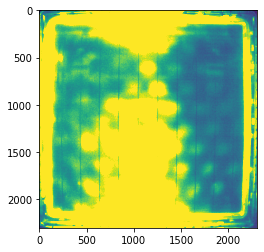

Event # 1 of type ID 1 contains banks CAM0
Received event with timestamp 1650451182 containing banks CAM0
2022-04-20 10:39:42, banks CAM0


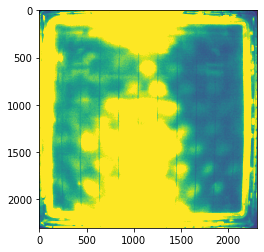

Event # 2 of type ID 1 contains banks CAM0
Received event with timestamp 1650451182 containing banks CAM0
2022-04-20 10:39:42, banks CAM0


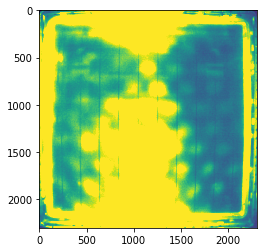

Event # 3 of type ID 1 contains banks CAM0
Received event with timestamp 1650451183 containing banks CAM0
2022-04-20 10:39:43, banks CAM0


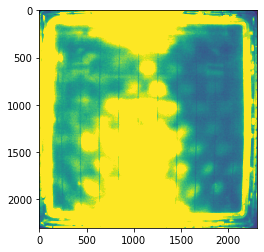

Event # 4 of type ID 1 contains banks CAM0
Received event with timestamp 1650451183 containing banks CAM0
2022-04-20 10:39:43, banks CAM0


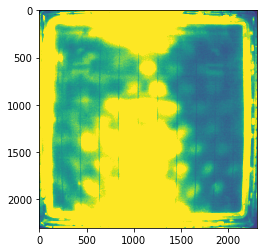

Event # 5 of type ID 1 contains banks CAM0
Received event with timestamp 1650451184 containing banks CAM0
2022-04-20 10:39:44, banks CAM0


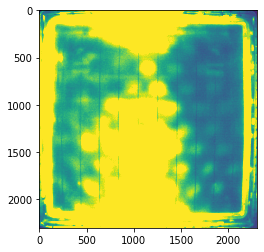

Event # 6 of type ID 1 contains banks CAM0
Received event with timestamp 1650451186 containing banks CAM0
2022-04-20 10:39:46, banks CAM0


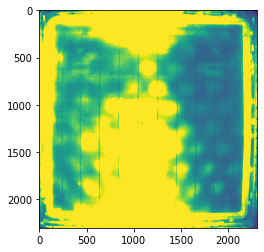

Event # 7 of type ID 1 contains banks CAM0
Received event with timestamp 1650451186 containing banks CAM0
2022-04-20 10:39:46, banks CAM0


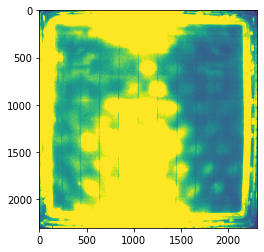

Event # 8 of type ID 1 contains banks CAM0
Received event with timestamp 1650451187 containing banks CAM0
2022-04-20 10:39:47, banks CAM0


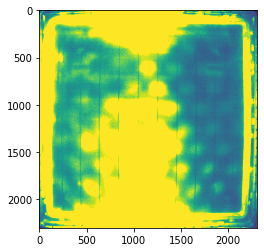

Event # 9 of type ID 1 contains banks CAM0
Received event with timestamp 1650451188 containing banks CAM0
2022-04-20 10:39:48, banks CAM0


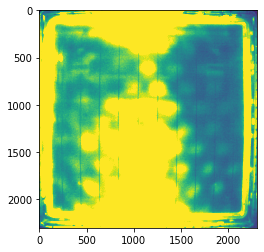

Event # 10 of type ID 1 contains banks CAM0
Received event with timestamp 1650451189 containing banks CAM0
2022-04-20 10:39:49, banks CAM0


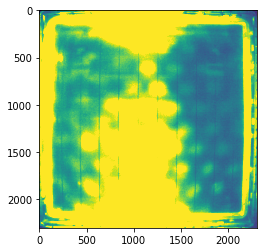

Event # 11 of type ID 1 contains banks CAM0
Received event with timestamp 1650451190 containing banks CAM0
2022-04-20 10:39:50, banks CAM0


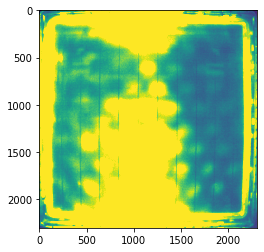

Event # 12 of type ID 1 contains banks CAM0
Received event with timestamp 1650451192 containing banks CAM0
2022-04-20 10:39:52, banks CAM0


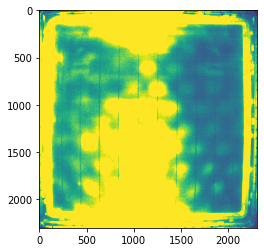

Event # 13 of type ID 1 contains banks CAM0
Received event with timestamp 1650451192 containing banks CAM0
2022-04-20 10:39:52, banks CAM0


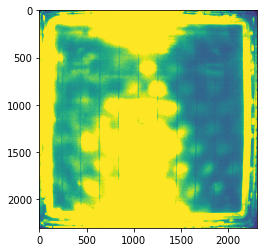

Event # 14 of type ID 1 contains banks CAM0
Received event with timestamp 1650451193 containing banks CAM0
2022-04-20 10:39:53, banks CAM0


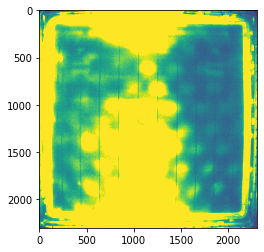

Event # 15 of type ID 1 contains banks CAM0
Received event with timestamp 1650451195 containing banks CAM0
2022-04-20 10:39:55, banks CAM0


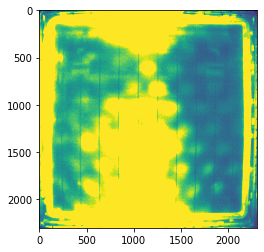

Event # 16 of type ID 1 contains banks CAM0
Received event with timestamp 1650451195 containing banks CAM0
2022-04-20 10:39:55, banks CAM0


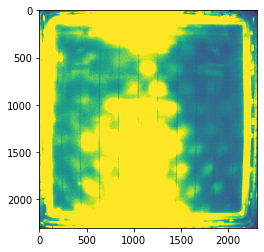

Event # 17 of type ID 1 contains banks CAM0
Received event with timestamp 1650451196 containing banks CAM0
2022-04-20 10:39:56, banks CAM0


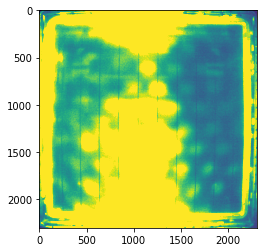

Event # 18 of type ID 1 contains banks CAM0
Received event with timestamp 1650451198 containing banks CAM0
2022-04-20 10:39:58, banks CAM0


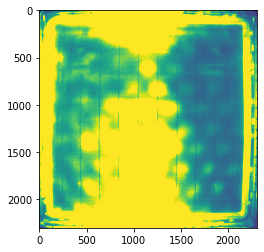

Event # 19 of type ID 1 contains banks CAM0
Received event with timestamp 1650451199 containing banks CAM0
2022-04-20 10:39:59, banks CAM0


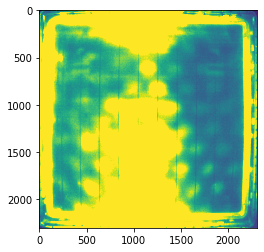

Event # 20 of type ID 1 contains banks CAM0
Received event with timestamp 1650451199 containing banks CAM0
2022-04-20 10:39:59, banks CAM0


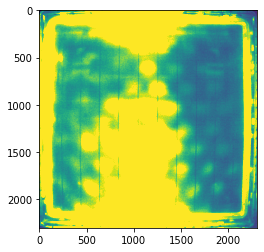

Event # 21 of type ID 1 contains banks CAM0
Received event with timestamp 1650451201 containing banks CAM0
2022-04-20 10:40:01, banks CAM0


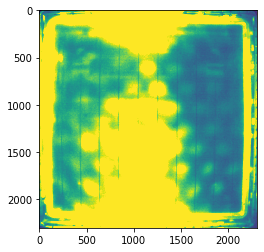

Event # 22 of type ID 1 contains banks CAM0
Received event with timestamp 1650451202 containing banks CAM0
2022-04-20 10:40:02, banks CAM0


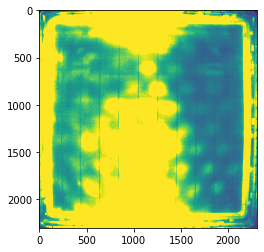

Event # 23 of type ID 1 contains banks CAM0
Received event with timestamp 1650451203 containing banks CAM0
2022-04-20 10:40:03, banks CAM0


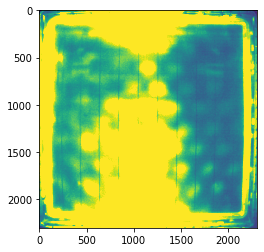

Event # 24 of type ID 1 contains banks CAM0
Received event with timestamp 1650451204 containing banks CAM0
2022-04-20 10:40:04, banks CAM0


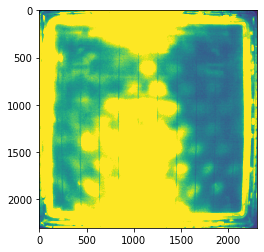

Event # 25 of type ID 1 contains banks CAM0
Received event with timestamp 1650451205 containing banks CAM0
2022-04-20 10:40:05, banks CAM0


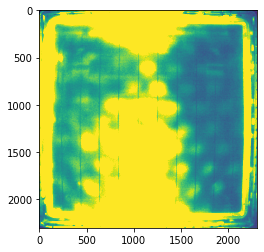

Event # 26 of type ID 1 contains banks CAM0
Received event with timestamp 1650451206 containing banks CAM0
2022-04-20 10:40:06, banks CAM0


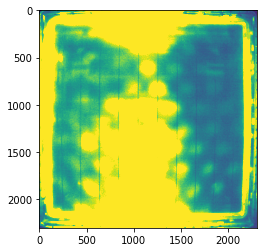

Event # 27 of type ID 1 contains banks CAM0
Received event with timestamp 1650451207 containing banks CAM0
2022-04-20 10:40:07, banks CAM0


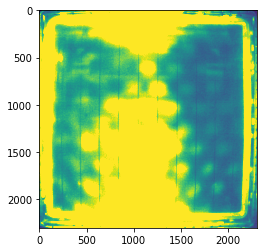

Event # 28 of type ID 1 contains banks CAM0
Received event with timestamp 1650451208 containing banks CAM0
2022-04-20 10:40:08, banks CAM0


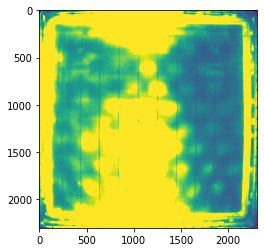

Event # 29 of type ID 1 contains banks CAM0
Received event with timestamp 1650451209 containing banks CAM0
2022-04-20 10:40:09, banks CAM0


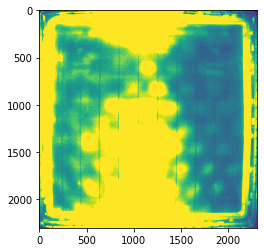

Event # 30 of type ID 1 contains banks CAM0
Received event with timestamp 1650451211 containing banks CAM0
2022-04-20 10:40:11, banks CAM0


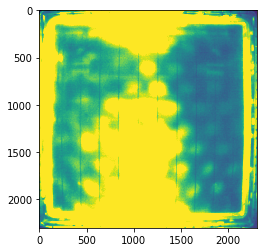

Event # 31 of type ID 1 contains banks CAM0
Received event with timestamp 1650451211 containing banks CAM0
2022-04-20 10:40:11, banks CAM0


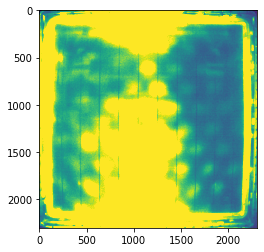

Event # 32 of type ID 1 contains banks CAM0
Received event with timestamp 1650451212 containing banks CAM0
2022-04-20 10:40:12, banks CAM0


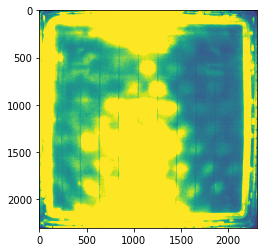

Event # 33 of type ID 1 contains banks CAM0
Received event with timestamp 1650451214 containing banks CAM0
2022-04-20 10:40:14, banks CAM0


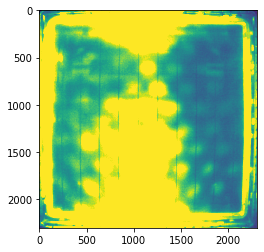

Saw a special event


In [12]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt

mfile = open_mid(run=89, path='/tmp/', cloud=True, tag='TMP', 
             verbose=True)

for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': 
            header = daq_dgz2header(bank)
            print (header)
            waveform = daq_dgz2array(event.banks['DIG0'], header)
        if bank_name=='CAM0': 
            image, _, _ = daq_cam2array(bank)
            plt.imshow(image, vmin=95, vmax=150)
            plt.show()
        if bank_name=='INPT': 
            slow = daq_slow2array(bank)


In [14]:
import urllib, os
from tqdm import tqdm
urllib = getattr(urllib, 'request', urllib)

class TqdmUpTo(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        return self.update(b * bsize - self.n)  # also sets self.n = b * bsize

eg_link = "https://caspersci.uk.to/matryoshka.zip"
with TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
              desc=eg_link.split('/')[-1]) as t:  # all optional kwargs
    urllib.urlretrieve(eg_link, filename=os.devnull,
                       reporthook=t.update_to, data=None)
    t.total = t.n

matryoshka.zip: 100%|██████████| 256k/256k [00:02<00:00, 96.9kB/s] 


In [435]:
import midas.file_reader
from datetime import datetime
import numpy as np

# Open our file
#mfile = midas.file_reader.MidasFile('/tmp/run00060.mid.gz')
#mfile = midas.file_reader.MidasFile("https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/TMP/run00111.mid.gz")
mfile = open_mid(run=60, path='/tmp/', cloud=True, tag='TMP', 
             verbose=True)
# We can simply iterate over all events in the file
for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='CAM0':
            shape_image = int(np.sqrt(bank.size_bytes*8/16))
            image = np.reshape(bank.data, (shape_image, shape_image))
        if bank_name=='DGH0':
            nboard = bank.data[0]
            ich = 1
            data_offset = 0
            for iboard in range(nboard):
                name_board = bank.data[ich]
                ich+=1
                sample_number = bank.data[ich]
                ich+=1
                channels_number =  bank.data[ich]
                ich+=1
                number_events = bank.data[ich]
                ich+=1
                vertical_resulution = bank.data[ich]
                ich+=1
                sampling_rate = bank.data[ich]
                cannaels_offset = [None] * channels_number
                for ichannels in range(channels_number):
                    ich+=1
                    cannaels_offset[ichannels] = bank.data[ich]
                Waveform = []
                for ievent in range(number_events):       
                    for ichannels in range(channels_number):
                        start = data_offset 
                        Waveform.append(bank.data[data_offset:data_offset+sample_number])
                        data_offset += sample_number
        if bank_names=='INPT':
            print(datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), 
                  "event: "+str(event.header.serial_number))
            print("  >>>  Entry in bank %s is %s" % (bank_names,bank.data))
            print(list(bank.data))

https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/TMP/run00060.mid.gz
https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/TMP/run00060.mid.gz
Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031417 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:30:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031417 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:30:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1648031417 containing banks DMND, MSRD
2022-03-23 10:30:17, banks DMND, MSRD
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031418 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:18, banks DIG0, DGH0, CAM0


file /tmp/run00060.mid.gz cached

Event # 1 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031423 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:23, banks DIG0, DGH0, CAM0
Event # 2 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031425 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:25, banks DIG0, DGH0, CAM0
Event # 3 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031429 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:29, banks DIG0, DGH0, CAM0
Event # 4 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031430 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:30, banks DIG0, DGH0, CAM0
Event # 5 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031437 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:37, banks DIG0, DGH0, CAM0
Event # 6 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031439 containing banks DIG0, DGH0, CAM0


Event # 39 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031502 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:42, banks DIG0, DGH0, CAM0
Event # 40 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031503 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:43, banks DIG0, DGH0, CAM0
Event # 41 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031507 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:47, banks DIG0, DGH0, CAM0
Event # 42 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031509 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:49, banks DIG0, DGH0, CAM0
Event # 1 of type ID 5 contains banks INPT
Received event with timestamp 1648031511 containing banks INPT
2022-03-23 10:31:51, banks INPT
2022-03-23 10:31:51 event: 1
  >>>  Entry in bank INPT is (nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 1.416945219039917, 2.470604181289673, 1.1381714344024658, 

Event # 76 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031574 containing banks DIG0, DGH0, CAM0
2022-03-23 10:32:54, banks DIG0, DGH0, CAM0
Event # 77 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031575 containing banks DIG0, DGH0, CAM0
2022-03-23 10:32:55, banks DIG0, DGH0, CAM0
Event # 78 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031577 containing banks DIG0, DGH0, CAM0
2022-03-23 10:32:57, banks DIG0, DGH0, CAM0
Event # 79 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031578 containing banks DIG0, DGH0, CAM0
2022-03-23 10:32:58, banks DIG0, DGH0, CAM0
Event # 80 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031579 containing banks DIG0, DGH0, CAM0
2022-03-23 10:32:59, banks DIG0, DGH0, CAM0
Event # 81 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031582 containing banks DIG0, DGH0,

Event # 114 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031646 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:06, banks DIG0, DGH0, CAM0
Event # 115 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031647 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:07, banks DIG0, DGH0, CAM0
Event # 116 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031649 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:09, banks DIG0, DGH0, CAM0
Event # 117 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031653 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:13, banks DIG0, DGH0, CAM0
Event # 118 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031654 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:14, banks DIG0, DGH0, CAM0
Event # 4 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031657 containing b

Event # 152 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031715 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:15, banks DIG0, DGH0, CAM0
Event # 5 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031717 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:35:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 5 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031717 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:35:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 5 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1648031717 containing banks DMND, MSRD
2022-03-23 10:35:17, banks DMND, MSRD
Event # 153 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031716 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:16, banks DIG0, DGH0, CAM0
Event # 154 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event 

Event # 6 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031777 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:36:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 6 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031777 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:36:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 6 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1648031777 containing banks DMND, MSRD
2022-03-23 10:36:17, banks DMND, MSRD
Event # 190 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031777 containing banks DIG0, DGH0, CAM0
2022-03-23 10:36:17, banks DIG0, DGH0, CAM0
Event # 191 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031778 containing banks DIG0, DGH0, CAM0
2022-03-23 10:36:18, banks DIG0, DGH0, CAM0
Event # 192 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event 

Event # 8 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1648031897 containing banks DMND, MSRD
2022-03-23 10:38:17, banks DMND, MSRD
Event # 218 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031897 containing banks DIG0, DGH0, CAM0
2022-03-23 10:38:17, banks DIG0, DGH0, CAM0
Event # 219 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031899 containing banks DIG0, DGH0, CAM0
2022-03-23 10:38:19, banks DIG0, DGH0, CAM0
Event # 220 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031901 containing banks DIG0, DGH0, CAM0
2022-03-23 10:38:21, banks DIG0, DGH0, CAM0
Event # 221 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031903 containing banks DIG0, DGH0, CAM0
2022-03-23 10:38:23, banks DIG0, DGH0, CAM0
Event # 222 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031905 containing banks DIG0, DGH0, CAM0
2022-03-

Event # 9 of type ID 5 contains banks INPT
Received event with timestamp 1648031991 containing banks INPT
2022-03-23 10:39:51, banks INPT
2022-03-23 10:39:51 event: 9
  >>>  Entry in bank INPT is (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -1.307329773902893, 1.470992088317871, -0.058868952095508575, -0.2754092514514923, 0.0, -0.001100392546504736, -0.0011618947610259056, -0.001101684756577015, -0.0011826283298432827, -0.001153640914708376, -0.001105933915823698, -0.001133966725319624, -0.0011575757525861263, 0.0)
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -1.307329773902893, 1.470992088317871, -0.058868952095508575, -0.2754092514514923, 0.0, -0.001100392546504736, -0.0011618947610259056, -0.001101684756577015, -0.0011826283298432827, -0.001153640914708376, -0.001105933915823698, -0.001133966725319624, -0.0011575757525861263, 0.0]
Event # 256 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031991 containing ban

In [15]:
import boto3
from boto3sts import credentials as creds
import cygno as cy

key = 'TMP/test.png'

aws_session = creds.assumed_session("infncloud-iam")
s3 = aws_session.client('s3', endpoint_url="https://minio.cloud.infn.it/", 
                        config=boto3.session.Config(signature_version='s3v4'),verify=True)
#response = s3.list_objects(Bucket='cygno-data')['Contents']
s3_head = s3.head_object(Bucket='cygno-data',Key=key)
s3_obj = s3.get_object(Bucket='cygno-data',Key=key)

In [21]:
import cygno as cy
cy.s3.kb2valueformat(s3_obj['ContentLength'])

(561.001953125, 'Kb')

In [22]:
from IPython.display import Image
Image(s3_obj['Body']._raw_stream.data) 

In [62]:

key = 'TMP/filetest.png.gz'
s3_head = s3.head_object(Bucket='cygno-data',Key=key)
s3_obj = s3.get_object(Bucket='cygno-data',Key=key)
cy.s3.kb2valueformat(s3_obj['ContentLength'])

(561.001953125, 'Kb')

In [63]:
from io import BytesIO
import gzip
buf = BytesIO(s3_obj["Body"]._raw_stream.data)

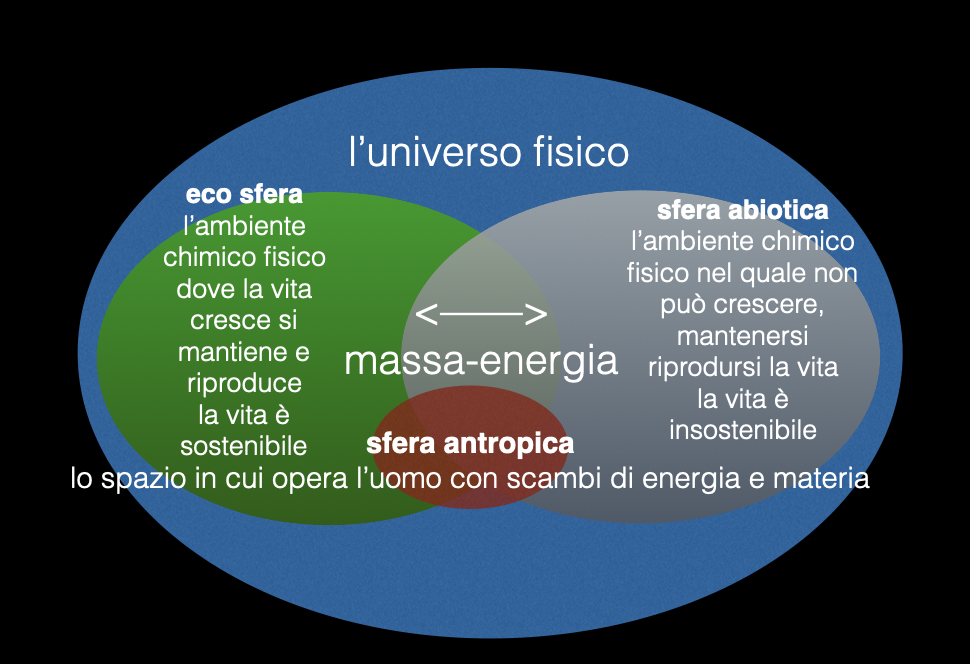

In [64]:
myfile = gzip.GzipFile(fileobj=buf)
Image(myfile.read()) 

In [71]:
s3_obj['Body']._raw_stream.info()
#s3_obj['Body']._raw_stream.data

HTTPHeaderDict({'Accept-Ranges': 'bytes', 'Content-Length': '574466', 'Content-Security-Policy': 'block-all-mixed-content', 'Content-Type': 'application/octet-stream', 'Date': 'Sun, 17 Apr 2022 16:40:42 GMT', 'Etag': '"b42fd9ab7daf2853f924ed6e43409c8e"', 'Last-Modified': 'Fri, 15 Apr 2022 13:56:35 GMT', 'Server': 'MinIO', 'Vary': 'Origin', 'X-Amz-Request-Id': '16E6BC90718FCF06', 'X-Xss-Protection': '1; mode=block'})

In [72]:


key = 'TMP/run00065.mid.gz'

aws_session = creds.assumed_session("infncloud-iam")
s3 = aws_session.client('s3', endpoint_url="https://minio.cloud.infn.it/", 
                        config=boto3.session.Config(signature_version='s3v4'),verify=True)
#response = s3.list_objects(Bucket='cygno-data')['Contents']
s3_head = s3.head_object(Bucket='cygno-data',Key=key)
s3_obj = s3.get_object(Bucket='cygno-data',Key=key)
cy.s3.kb2valueformat(s3_obj['ContentLength'])

(14.660876274108887, 'Mb')

In [73]:
from io import BytesIO
import gzip
from datetime import datetime
import numpy as np
buf = BytesIO(s3_obj["Body"]._raw_stream.data)
myfile = gzip.GzipFile(fileobj=buf)

In [75]:
class MidasSream:
    """
    Provides access to a midas file - either raw (.mid), gzipped (.mid.gz) or lz4 (.mid.lz4).
    
    Members:
        
    * file (file-like object)
    * event (`Event`) - The event we've just read
    * next_event_offset (int) - Position in file where the next event starts
    * this_event_payload_offset (int) - Sometimes we just read the event header,
        not the full data. This member is where the data of the current event starts.
    * use_numpy (bool) - Whether to use numpy when extracting bank contents (so bank
        data is a numpy array rather than a standard python tuple)
    """
    def __init__(self, path, use_numpy=False):
        """
        Open a midas file.
        
        Args:
            
        * path (str) - Path to the file
        * use_numpy (bool) - Whether to use numpy when extracting bank contents (so bank
            data is a numpy array rather than a standard python tuple)
        """
        self.file = None
        self.event = None
        self.next_event_offset = 0
        self.this_event_payload_offset = 0
        self.use_numpy = use_numpy
        self.reset_event()
        self.open(path)
        
        
    def __del__(self):
        """
        Clean up file handle when we go out of scope.
        """
        if self.file:
            self.file.close()
        
    def __next__(self):
        """
        Iterable interface for looping through events.
        """
        ev = self.read_next_event()
        
        if not ev:
            raise StopIteration()
        else:
            return ev
    
    next = __next__ # for Python 2        
        
    def __iter__(self):
        """
        Iterable interface for looping through events.
        """
        return self
        
    def reset_event(self):
        """
        Forget about an event we've already read (but don't rewind
        the actual file pointer).
        """
        self.event = midas.event.Event()
        self.this_event_payload_offset = 0
        
    def open(self, path):
            self.file = path
    
    def jump_to_start(self):
        """
        Rewind to the start of the file.
        """
        self.file.seek(0,0)
        self.next_event_offset = 0
        self.reset_event()
    
    def get_bor_odb_dump(self):
        """
        Return the begin-of-run ODB dump as a string (containing XML).
        
        We will jump to the correct place in the file automatically.
        """
        self.jump_to_start()
        
        if self.read_next_event_header() and self.event.header.is_bor_event():
            self.read_this_event_body()
            return Odb(self.event.non_bank_data)
        
        self.jump_to_start()
        raise RuntimeError("Unable to find BOR event")
    
    def get_eor_odb_dump(self):
        """
        Return the end-of-run ODB dump as a string (containing XML).
        
        We will jump to the correct place in the file automatically.
        """
        while True:
            if not self.read_next_event_header():
                break
        
            if self.event.header.is_eor_event():
                self.read_this_event_body()
                return Odb(self.event.non_bank_data)
        
        self.jump_to_start()
        raise RuntimeError("Unable to find EOR event")
    
    def get_next_event_with_bank(self, bank_name):
        """
        Find the next event that contain a bank with the specified name.
        
        Returns:
            `Event`, or None of no such event found.
        """
        while self.read_next_event():
            if bank_name in self.event.banks.keys():
                return self.event
            
        return None
    
    def read_next_event(self):
        """
        Read the header and content of the next event.
        May be slow if there is a lot of data.
        
        Returns:
            `Event`, of None if no more events left.
        """
        if self.read_next_event_header():
            return self.read_this_event_body()
        else:
            return None
    
    def read_next_event_header(self):
        """
        Just read the header/metadata of the next event.
        If you read it and think it's interesting, you can then call
        read_this_event_body() to grab the actual data.
        If the event isn't interesting, then you saved yourself a lot
        of time by not loading a bunch of data you don't care about.
        
        Returns:
            `Event` (with only the header populated), or None if no
            more events left.
        """
        self.reset_event()
        this_event_offset = self.next_event_offset
        
        self.file.seek(self.next_event_offset, 0)
        header_data = self.file.read(midas.event.event_header_size)
        
        if not header_data:
            return None
        
        self.event.header.fill_from_bytes(header_data)
        
        self.this_event_payload_offset = this_event_offset + midas.event.event_header_size
        self.next_event_offset += self.event.header.event_data_size_bytes + midas.event.event_header_size
        
        return self.event
    
    def read_this_event_body(self):
        """
        Read the data of the current event (that you've already read the header info of).
        
        Populates event.banks or event.non_bank_data (depending on the event type).
        
        Returns:
            `Event` (with both the header and body populated)
        """
        self.file.seek(self.this_event_payload_offset, 0)
        body_data = self.file.read(self.event.header.event_data_size_bytes)
        self.event.unpack_body(body_data, 0, self.use_numpy)
        return self.event

    def get_event_count(self, include_midas_special_events=False):
        """
        Count the number of events in this file.
        
        Args:
            * include_midas_special_events (bool) - Whether to include
                midas' internal events in the count (begin-of-run, message and 
                end-of-run events).
        
        Returns:
            int
        """
        self.jump_to_start()
        count = 0
        
        while self.read_next_event_header():
            if self.event.header.is_midas_internal_event() and not include_midas_special_events:
                continue
            
            count += 1
            
        self.jump_to_start()
        return count

In [111]:
from io import BytesIO
import gzip
from datetime import datetime
import numpy as np
import boto3
from boto3sts import credentials as creds
import cygno as cy

key = 'TMP/run00060.mid.gz'
print("key: ", key)

aws_session = creds.assumed_session("infncloud-iam")
s3 = aws_session.client('s3', endpoint_url="https://minio.cloud.infn.it/", 
                        config=boto3.session.Config(signature_version='s3v4'),verify=True)

s3_head = s3.head_object(Bucket='cygno-data',Key=key)
print("s3_head", s3_head)
s3_obj = s3.get_object(Bucket='cygno-data',Key=key)
print(cy.s3.kb2valueformat(s3_obj['ContentLength']))

buf = BytesIO(s3_obj["Body"]._raw_stream.data)

print("data load")

for event in MidasSream(gzip.GzipFile(fileobj=buf)):
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))


key:  TMP/run00060.mid.gz
s3_head {'ResponseMetadata': {'RequestId': '16E70C03A6C27B85', 'HostId': '', 'HTTPStatusCode': 200, 'HTTPHeaders': {'accept-ranges': 'bytes', 'content-length': '1492040346', 'content-security-policy': 'block-all-mixed-content', 'content-type': 'application/octet-stream', 'date': 'Mon, 18 Apr 2022 16:56:38 GMT', 'etag': '"b6b0acb04f91492ec22ad3a496c08e27-178"', 'last-modified': 'Mon, 11 Apr 2022 15:34:34 GMT', 'server': 'MinIO', 'vary': 'Origin', 'x-amz-request-id': '16E70C03A6C27B85', 'x-xss-protection': '1; mode=block'}, 'RetryAttempts': 0}, 'AcceptRanges': 'bytes', 'LastModified': datetime.datetime(2022, 4, 11, 15, 34, 34, tzinfo=tzutc()), 'ContentLength': 1492040346, 'ETag': '"b6b0acb04f91492ec22ad3a496c08e27-178"', 'ContentType': 'application/octet-stream', 'Metadata': {}}
(1.3895708564668894, 'Gb')
data load
Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031417 containing banks DMND

Event # 37 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031498 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:38, banks DIG0, DGH0, CAM0
Event # 38 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031499 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:39, banks DIG0, DGH0, CAM0
Event # 39 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031502 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:42, banks DIG0, DGH0, CAM0
Event # 40 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031503 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:43, banks DIG0, DGH0, CAM0
Event # 41 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031507 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:47, banks DIG0, DGH0, CAM0
Event # 42 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031509 containing banks DIG0, DGH0,

Event # 79 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031578 containing banks DIG0, DGH0, CAM0
2022-03-23 10:32:58, banks DIG0, DGH0, CAM0
Event # 80 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031579 containing banks DIG0, DGH0, CAM0
2022-03-23 10:32:59, banks DIG0, DGH0, CAM0
Event # 81 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031582 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:02, banks DIG0, DGH0, CAM0
Event # 82 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031583 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:03, banks DIG0, DGH0, CAM0
Event # 83 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031587 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:07, banks DIG0, DGH0, CAM0
Event # 84 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031589 containing banks DIG0, DGH0,

Event # 122 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031659 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:19, banks DIG0, DGH0, CAM0
Event # 123 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031662 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:22, banks DIG0, DGH0, CAM0
Event # 124 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031663 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:23, banks DIG0, DGH0, CAM0
Event # 125 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031667 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:27, banks DIG0, DGH0, CAM0
Event # 126 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031669 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:29, banks DIG0, DGH0, CAM0
Event # 127 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031671 containing banks DIG0,

Event # 165 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031739 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:39, banks DIG0, DGH0, CAM0
Event # 166 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031741 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:41, banks DIG0, DGH0, CAM0
Event # 167 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031743 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:43, banks DIG0, DGH0, CAM0
Event # 168 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031744 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:44, banks DIG0, DGH0, CAM0
Event # 169 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031746 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:46, banks DIG0, DGH0, CAM0
Event # 170 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031748 containing banks DIG0,

Event # 204 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031871 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:51, banks DIG0, DGH0, CAM0
Event # 205 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031873 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:53, banks DIG0, DGH0, CAM0
Event # 206 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031875 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:55, banks DIG0, DGH0, CAM0
Event # 207 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031877 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:57, banks DIG0, DGH0, CAM0
Event # 208 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031878 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:58, banks DIG0, DGH0, CAM0
Event # 209 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031880 containing banks DIG0,

Event # 246 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031967 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:27, banks DIG0, DGH0, CAM0
Event # 247 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031968 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:28, banks DIG0, DGH0, CAM0
Event # 248 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031970 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:30, banks DIG0, DGH0, CAM0
Event # 249 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031972 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:32, banks DIG0, DGH0, CAM0
Event # 250 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031975 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:35, banks DIG0, DGH0, CAM0
Event # 251 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031979 containing banks DIG0,

In [86]:
import requests
key = 'TMP/run00066.mid.gz'
url = BASE_URL  = BAKET_REST_PATH+'cygno-data/'+key
print(url)
out = requests.get(url)

https://s3.cloud.infn.it/v1/AUTH_2ebf769785574195bde2ff418deac08a/cygno-data/TMP/run00066.mid.gz


In [106]:
import requests
key = 'TMP/run00064.mid.gz'
url = BASE_URL  = BAKET_REST_PATH+'cygno-data/'+key
#out = requests.get(url)
buf = BytesIO(requests.get(url).content)
for event in MidasSream(gzip.GzipFile(fileobj=buf)):
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))


Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648046443 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 14:40:43, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648046443 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 14:40:43, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1648046443 containing banks DMND, MSRD
2022-03-23 14:40:43, banks DMND, MSRD
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648046444 containing banks DIG0, DGH0, CAM0
2022-03-23 14:40:44, banks DIG0, DGH0, CAM0
Event # 1 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648046446 containing banks DIG0, DGH0, CAM0
2022-03-23 14:40:46, banks DIG0, DGH0, CAM0
Event # 2 of type ID 1 contains banks DIG0, DGH0, CAM0
R

In [107]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [109]:
import requests
key = 'TMP/run00060.mid.gz'
url = BASE_URL  = BAKET_REST_PATH+'cygno-data/'+key
for event in MidasSream(gzip.GzipFile(fileobj=BytesIO(requests.get(url).content))):
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))


Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031417 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:30:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031417 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-03-23 10:30:17, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1648031417 containing banks DMND, MSRD
2022-03-23 10:30:17, banks DMND, MSRD
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031418 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:18, banks DIG0, DGH0, CAM0
Event # 1 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031423 containing banks DIG0, DGH0, CAM0
2022-03-23 10:30:23, banks DIG0, DGH0, CAM0
Event # 2 of type ID 1 contains banks DIG0, DGH0, CAM0
R

Event # 41 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031507 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:47, banks DIG0, DGH0, CAM0
Event # 42 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031509 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:49, banks DIG0, DGH0, CAM0
Event # 1 of type ID 5 contains banks INPT
Received event with timestamp 1648031511 containing banks INPT
2022-03-23 10:31:51, banks INPT
Event # 43 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031510 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:50, banks DIG0, DGH0, CAM0
Event # 44 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031513 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:53, banks DIG0, DGH0, CAM0
Event # 45 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031514 containing banks DIG0, DGH0, CAM0
2022-03-23 10:31:54, banks DIG0

Event # 83 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031587 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:07, banks DIG0, DGH0, CAM0
Event # 84 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031589 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:09, banks DIG0, DGH0, CAM0
Event # 85 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031590 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:10, banks DIG0, DGH0, CAM0
Event # 86 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031593 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:13, banks DIG0, DGH0, CAM0
Event # 87 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031594 containing banks DIG0, DGH0, CAM0
2022-03-23 10:33:14, banks DIG0, DGH0, CAM0
Event # 3 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1648031597 containing banks 

Event # 125 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031667 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:27, banks DIG0, DGH0, CAM0
Event # 126 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031669 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:29, banks DIG0, DGH0, CAM0
Event # 127 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031671 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:31, banks DIG0, DGH0, CAM0
Event # 128 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031673 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:33, banks DIG0, DGH0, CAM0
Event # 129 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031674 containing banks DIG0, DGH0, CAM0
2022-03-23 10:34:34, banks DIG0, DGH0, CAM0
Event # 130 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031677 containing banks DIG0,

Event # 168 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031744 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:44, banks DIG0, DGH0, CAM0
Event # 169 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031746 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:46, banks DIG0, DGH0, CAM0
Event # 170 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031748 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:48, banks DIG0, DGH0, CAM0
Event # 5 of type ID 5 contains banks INPT
Received event with timestamp 1648031751 containing banks INPT
2022-03-23 10:35:51, banks INPT
Event # 171 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031750 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:50, banks DIG0, DGH0, CAM0
Event # 172 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031752 containing banks DIG0, DGH0, CAM0
2022-03-23 10:35:52, banks

Event # 206 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031875 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:55, banks DIG0, DGH0, CAM0
Event # 207 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031877 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:57, banks DIG0, DGH0, CAM0
Event # 208 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031878 containing banks DIG0, DGH0, CAM0
2022-03-23 10:37:58, banks DIG0, DGH0, CAM0
Event # 209 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031880 containing banks DIG0, DGH0, CAM0
2022-03-23 10:38:00, banks DIG0, DGH0, CAM0
Event # 210 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031882 containing banks DIG0, DGH0, CAM0
2022-03-23 10:38:02, banks DIG0, DGH0, CAM0
Event # 211 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031884 containing banks DIG0,

Event # 248 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031970 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:30, banks DIG0, DGH0, CAM0
Event # 249 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031972 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:32, banks DIG0, DGH0, CAM0
Event # 250 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031975 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:35, banks DIG0, DGH0, CAM0
Event # 251 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031979 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:39, banks DIG0, DGH0, CAM0
Event # 252 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031983 containing banks DIG0, DGH0, CAM0
2022-03-23 10:39:43, banks DIG0, DGH0, CAM0
Event # 253 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1648031984 containing banks DIG0,